# Aufgabe 5: Separierbarkeit der Gauß-Filterung
Als effizientere Variante kann eine zweidimensionale lineare Filterung auf zwei eindimensionale lineare Filterungen reduziert werden.

Ein linearer zweidimensionaler Filter $A \in \mathbb{R}^{m \times n}$ heißt separierbar, wenn er durch Faltung zweier eindimensionaler Filter dargestellt werden kann:
\begin{align}
 A &= D_1 * D_2, \qquad \text{mit $D_1 \in \mathbb{R}^m, D_2 \in \mathbb{R}^n$}\\
                &= D_1 \cdot D_2^\top,  \qquad \text{(da $D_1,D_2$ Vektoren).}
\end{align}
Somit ergibt sich die Faltung zu
\begin{align}
  I * A &= I * (D_1 * D_2)\\
        &= (I * D_1) * D_2 \qquad \text{(Assoziativität der Faltung)}
\end{align}


Implementieren Sie nun die 2-D-Gaußfilterung als Hintereinanderausführung je eines Gaußfilters in vertikaler und horizontaler Richtung!

Vergleichen Sie die Laufzeiten mit der nicht-separierten Filterung für verschiedene Größen der Filtermaske!

## 0. Pfade, Pakete etc.

In [60]:
import glob
import urllib.request
import time

%matplotlib inline
import matplotlib.pyplot as plt

import PIL.Image
import numpy as np

In [61]:
image_filter = '../Bilder/*.jpg' # habe ich letzte mal schon hochgeladen.

## 1. Definition der Faltungsmaske
Definieren Sie hier wie in der vorherigen Aufgabe zunächst die Parameter `m` und `sigma` des Filters. Berechnen Sie anschließend eine eindimensionale Filtermaske `A_gauss`!

In [62]:
def gaussian_kernel_1d(size, sigma=None):
    if sigma is None:
        sigma = size / 5
    coords = np.arange(-(size // 2), size // 2 + 1, dtype=np.float32)
    kernel = np.exp(-(coords**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel.astype(np.float32)

def gaussian_kernel(size, sigma=None):
    if sigma is None:
        sigma = size / 5
    coords = np.arange(-(size // 2), size // 2 + 1, dtype=np.float32)
    xx, yy = np.meshgrid(coords, coords)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel.astype(np.float32)

m = 5

A_gauss_1d = gaussian_kernel_1d(m)
A_gauss = gaussian_kernel(m)
A_gauss_1d, A_gauss

(array([0.05448869, 0.24420136, 0.40261996, 0.24420136, 0.05448869],
       dtype=float32),
 array([[0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902],
        [0.01330621, 0.05963429, 0.09832033, 0.05963429, 0.01330621],
        [0.02193823, 0.09832033, 0.16210282, 0.09832033, 0.02193823],
        [0.01330621, 0.05963429, 0.09832033, 0.05963429, 0.01330621],
        [0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902]],
       dtype=float32))

## 2. Laden des Bildes

In [63]:
image_path = np.random.choice(glob.glob(image_filter))
image = np.asarray(PIL.Image.open(image_path).convert('L'))

Für diese Aufgabe ist es wichtig, das Bild im Fließkommaformat vorliegen zu haben. Konvertieren sie `image` zu einer geeigneten Repräsentation:

In [64]:
image = np.asarray(image, dtype=np.float32) / 255

## 3. Berechung der Faltung
Setzen Sie hier die Funktion `ex2_convolve` aus der vorherigen Aufgabe ein:

In [65]:
def ex2_convolve(image, filter_mask):
    mask = np.asarray(filter_mask, dtype=np.float32)

    image = np.asarray(image, dtype=np.float32)

    m, n = mask.shape
    pad_y, pad_x = m // 2, n // 2
    padded = np.pad(image, ((pad_y, pad_y), (pad_x, pad_x)), mode="edge")
    windows = np.lib.stride_tricks.sliding_window_view(padded, mask.shape)
    return np.einsum("ijmn,mn->ij", windows, mask, optimize=True)

def ex2_convolve_naive(image, filter_mask):
    mask = np.asarray(filter_mask, dtype=np.float32)

    m, n = mask.shape
    pad_y, pad_x = m // 2, n // 2
    pad_width = ((pad_y, pad_y), (pad_x, pad_x))
    

    padded = np.pad(image, pad_width=pad_width, mode="edge")
    convolved_image = np.zeros_like(image, dtype=np.float32)

    rows, cols = image.shape[:2]
    for i in range(rows):
        for j in range(cols):
            window = padded[i : i + m, j : j + n]
            if image.ndim == 2:
                convolved_image[i, j] = np.sum(window * mask)
            else:
                convolved_image[i, j, :] = np.tensordot(window, mask, axes=([0, 1], [0, 1]))

    return convolved_image

## 4. Separierter Gauß-Filter

Berechnen Sie nun das gefaltete Bild durch zwei Aufrufe der obigen Funktion! Tipp: Verwenden Sie die Funktion `transpose` aus dem Paket `numpy`, um die Filtermaske zu transponieren.

In [66]:
%%time
A_vert = A_gauss_1d[:, None]
A_horiz = A_gauss_1d[None, :]

intermediate = ex2_convolve(image, A_vert)
convolved_image = ex2_convolve(intermediate, A_horiz)

CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 13.1 ms


## 5. Darstellung
Um die Wirksamkeit des separierten Gauß-Filters zu überprüfen, stellen Sie `image` und `convolved_image` nebeneinander dar:

(np.float64(-0.5), np.float64(2559.5), np.float64(1439.5), np.float64(-0.5))

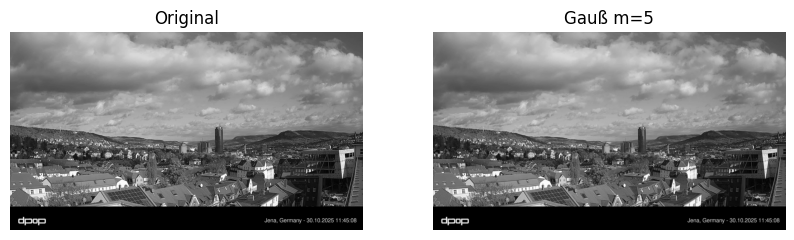

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image, cmap="gray", vmin=0, vmax=1)
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(convolved_image, cmap="gray", vmin=0, vmax=1)
ax[1].set_title("Gauß m=5")
ax[1].axis("off")


## 6. Laufzeitvergleich für verschiedene Filtergrößen

Vergleichen Sie die Laufzeit der separierten Filterung mit der der 2D-Filterung für verschieden große Filtermasken!

Zur Zeitmessung können Sie die magische Jupyter-Funktion `%time` (pro Zeile) oder `%%time` (pro Zelle) verwenden.

In [ ]:
mask_sizes = [3, 5, 9, 15, 21]
two_d_timings = []

for size in mask_sizes:
    kernel_2d = gaussian_kernel(size)
    start = time.perf_counter()
    _ = ex2_convolve_naive(image, kernel_2d)
    two_d_timings.append((size, time.perf_counter() - start))

In [ ]:
separable_timings = []

for size in mask_sizes:
    kernel_1d = gaussian_kernel_1d(size)
    start = time.perf_counter()
    intermediate = ex2_convolve_naive(image, kernel_1d[:, None])
    _ = ex2_convolve_naive(intermediate, kernel_1d[None, :])
    separable_timings.append((size, time.perf_counter() - start))

In [ ]:
print(f"{'size':>5} {'2D (s)':>10} {'sep (s)':>10} {'ratio':>10}")
for (size, t2d), (_, tsep) in zip(two_d_timings, separable_timings):
    print(f"{size:5d} {t2d:10.4f} {tsep:10.4f} {t2d / tsep:10.2f}")

 size     2D (s)    sep (s)      ratio
    3     0.0258     0.0287       0.90
    5     0.0660     0.0218       3.03
    9     0.3612     0.0240      15.05
   15     1.4717     0.0278      52.88
   21     2.7660     0.0318      87.08
